## Imports & parameters

In [16]:
%matplotlib inline

In [26]:
import pandas as pd
from sktime.utils.plotting import plot_series
from scipy.stats import shapiro
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.utils.plotting import plot_series
from sktime.forecasting.sarimax import SARIMAX
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')

In [18]:
horizon = 12

file_path = '../data/train.csv'

## Data processing

In [19]:
ts = pd.read_csv(file_path, index_col=0).squeeze("columns")
ts.head(), len(ts)

(01.01.15    1.91157
 01.02.15    1.44733
 01.03.15    1.89355
 01.04.15    2.03274
 01.05.15    2.27843
 Name: y, dtype: float64,
 86)

In [20]:
ts.dropna(inplace=True, how='all')
len(ts)

74

In [21]:
ts.index = pd.PeriodIndex(pd.to_datetime(ts.index, format='%d.%m.%y'), freq='M')
ts.head()

2015-01    1.91157
2015-02    1.44733
2015-03    1.89355
2015-04    2.03274
2015-05    2.27843
Freq: M, Name: y, dtype: float64

In [22]:
# Interpolate missing periods (if any)
ts = ts.interpolate(method="time")
len(ts)

74

## Data exploration

**Augmented Dickey-Fuller test**<br>
- H0: the series is non-stationary<br>
- H1: the series is stationary<br>
  
If the p-value is less than a chosen significance level (e.g., 0.05), reject the null hypothesis.

H0 rejected: the time series is stationary

In [28]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(ts)
p = result[1]

# Interpret the results
alpha = 0.05
if p > alpha:
    print("Data is non-stationary (fail to reject H0)")
else:
    print("Data is stationary (reject H0)")

Data is stationary (reject H0)


**Normally distributed data?**

<AxesSubplot:ylabel='Frequency'>

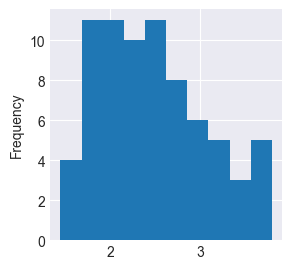

In [25]:
plt.figure(figsize=(3,3))
ts.plot.hist()

In [27]:
# Perform Shapiro-Wilk test
stat, p = shapiro(ts)

alpha = 0.05
if p > alpha:
    print("Data looks normally distributed (fail to reject H0)")
else:
    print("Data does not look normally distributed (reject H0)")

Data does not look normally distributed (reject H0)


**Autocorrelation**<br>
- ACF helps identify the presence of seasonality and trend in the time series (MA order).<br>
- PACF helps identify the lag beyond which autocorrelation becomes negligible (AR order).

From the ACF and PACF, we can assume that the time series follows SARIMA(1,0,1)(0,0,1)12

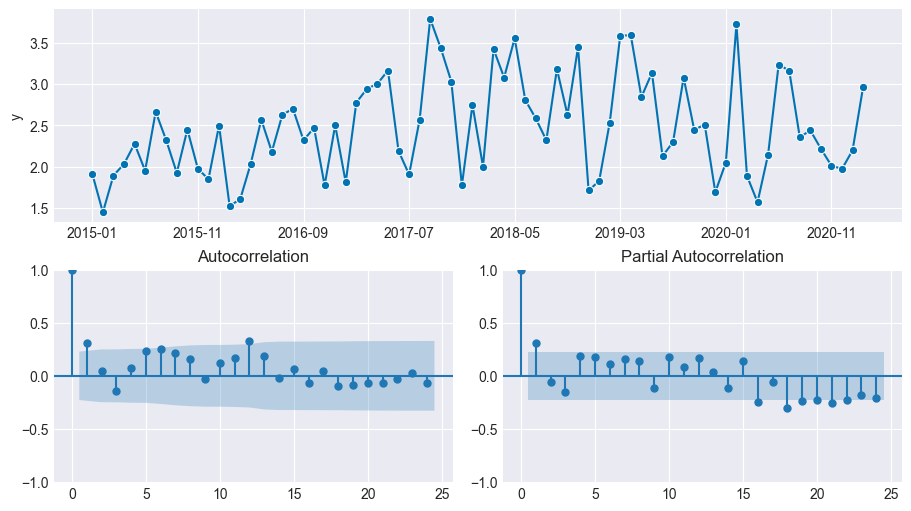

In [9]:
from sktime.utils.plotting import plot_correlations

fig, ax = plot_correlations(ts)
fig.set_size_inches(9, 5)
plt.show()

**Visual exploration of seasonality**<br>

The yearly seasonality is not observed, as there is no clear tendency observed year over year.

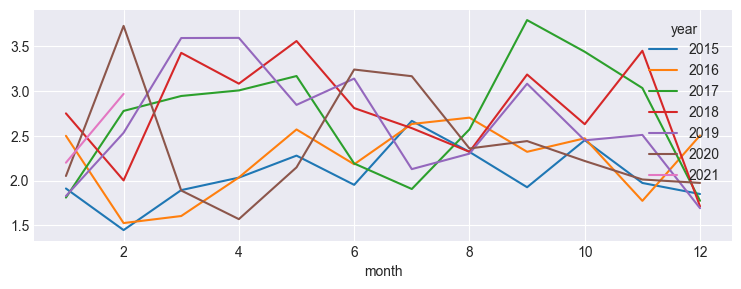

In [10]:
df = ts.to_frame()
df['date'] = df.index.to_timestamp()
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

pv = pd.pivot_table(df, index=df.month, columns=df.year,
                    values='y', aggfunc='sum')
pv.plot()
plt.gcf().set_size_inches(9, 3)
plt.show()

## Data modeling

The SARIMA model was utilized as the baseline. Initial results appear promising upon visual inspection of the predictions. However, it tends to forecast higher values than the actuals, likely due to the influence of the high last value in the training set.<br>
Note: The ConvergenceWarning indicates suggests that the optimization algorithm may not have found the optimal parameters for the model. Requiere further investigation.

c:\Users\chubey\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='y'>)

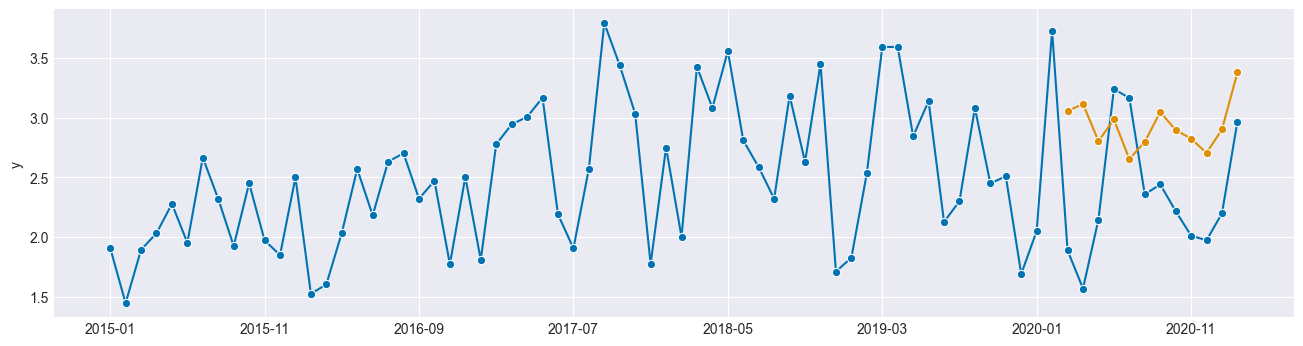

In [11]:
y_train, y_test = temporal_train_test_split(ts, test_size=horizon)
fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = SARIMAX(order=(1, 0, 1), trend="t", seasonal_order=(0, 0, 1, 12))
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(ts, y_pred)

In [12]:
mae = mean_absolute_error(y_test, y_pred)

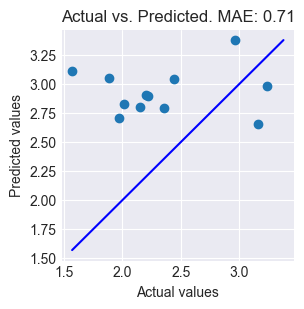

In [13]:
# Plot scatterplot
plt.figure(figsize=(3,3))
plt.scatter(y_test, y_pred)
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title(f'Actual vs. Predicted. MAE: {mae:.2f}')
plt.show()
